第14回の演習です。CNN（畳み込みニューラルネットワーク）を実装します。
左上の「ファイル」＞「ドライブにコピーを保存」を選択して、Google DriveにNotebookを保存します。ご自身のGoogleドライブの"Colab Notebooks"フォルダで、保存したNotebookを右クリックし、「アプリで開く」＞「Google Colaboratory」を選択します。その上で、各コードを実行するには、以下のコマンドを実行してください。実行は「再生」ボタンを押します。

In [ ]:
print("Chapter 14")

Chapter 14


# CNN
前回、Kerasでニューラルネットワークを構築し、Fashion-MNISTデータセットのアイテム画像を認識するというタスクに対してハイパーパラメータを調整しました。その正確度（識別率）は約86%まで改善しましたが、まだ、scikit-learnライブラリのニューラルネットワークのそれには及びません。ここで、畳み込み処理とプーリング処理を導入し、CNNを構築します。

## GPUの利用
時間がかかるので、GPUを使います。Coogle Colaboratoryのメニュー「ランライム」をクリックし、「ランタイムのタイプを変更」を選択します。「ハードウェアアクセラレータ」を"GPU"に変更します。これで計算処理が多少速く終了するようになるでしょう。ただ、「Colabでの使用量上限に達したため、現在GPUに接続できません」というメッセージが出ると、GPUが割り当てられないこともあります。

## データセットの用意と前処理
まずはデータセットを用意し、前処理を済ませます。これらはこの回では共通の操作ですので、一度実行しておけばよいでしょう。ただし、「ランタイムリセット」されてしまったら再実行します。

In [ ]:
# Fashion-MNISTデータセット
from tensorflow.keras.datasets import fashion_mnist
(train_data, train_label), (test_data, test_label) = fashion_mnist.load_data()

# Fashion-MNISTのデータ形状
print(train_data.shape)         # 学習用データ
print(train_label.shape)        # 学習用データのラベル
print(test_data.shape)          # 検証用データ
print(test_label.shape)         # 検証用データのラベル


# データの形状を確認------------------------------
import numpy as np
# データ抽出
train_data0 = train_data[0:10000, : , : ]
train_label0 = train_label[0:10000]
valid_data0 = train_data[10000:11000, : , : ]
valid_label0 = train_label[10000:11000]

# データ型
print(train_data0.dtype, valid_data0.dtype)
print(train_data0.shape, valid_data0.shape)

# uint8 -> float32（<-この下の「channelの追加」取りやめに伴う変更＠20221021）
# train_data01 = train_data0.astype("float32") / 255
train_data1 = train_data0.astype("float32") / 255
# valid_data01 = valid_data0.astype("float32") / 255
valid_data1 = valid_data0.astype("float32") / 255

# channelの追加（<-この「channelの追加」と取りやめる＠20221021）
# train_data1 = train_data01.reshape(train_data01.shape[0], train_data01.shape[1], train_data01.shape[2], 1)
# valid_data1 = valid_data01.reshape(valid_data01.shape[0], valid_data01.shape[1], valid_data01.shape[2], 1)

# データ型
print(train_data1.dtype, valid_data1.dtype)
print(train_data1.shape, valid_data1.shape)

print("学習用データ")
print(train_data1.min(), "-", train_data1.max())
print(train_label0.min(), "-", train_label0.max())
print("検証用データ")
print(valid_data1.min(), "-", valid_data1.max())
print(valid_label0.min(), "-", valid_label0.max())


# one-hotベクトルに変換----------------------
# keras.utilsからto_categoricalをインポート
from tensorflow.keras.utils import to_categorical

# ラベルの表示
print("学習用", train_label0, len(train_label0))
print("検証用", valid_label0, len(valid_label0))

# one-hot vector
train_label1 = to_categorical(train_label0)
valid_label1 = to_categorical(valid_label0)

print("学習用", train_label1, len(train_label1))
print("検証用", valid_label1, len(valid_label1))

4422102/4422102 [==============================] - 0s 0us/step
(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)
uint8 uint8
(10000, 28, 28) (1000, 28, 28)
float32 float32
(10000, 28, 28) (1000, 28, 28)
学習用データ
0.0 - 1.0
0 - 9
検証用データ
0.0 - 1.0
0 - 9
学習用 [9 0 0 ... 0 6 6] 10000
検証用 [8 7 6 8 7 7 2 0 5 3 5 5 1 3 9 4 1 9 3 2 8 2 9 3 4 5 1 0 3 2 8 5 3 8 2 2 9
 7 7 9 9 1 2 6 7 6 6 6 6 7 3 7 8 5 9 5 9 1 5 9 8 3 6 1 1 0 3 3 1 2 9 8 9 5
 1 0 6 2 3 0 0 8 8 5 7 3 6 9 7 3 6 4 8 5 0 8 3 6 7 1 5 1 7 6 4 1 6 9 8 1 1
 7 7 0 7 4 9 4 2 9 9 9 6 5 2 3 5 6 5 1 9 6 1 5 6 9 3 5 3 5 3 2 7 0 9 1 1 2
 1 3 6 4 8 4 1 3 2 6 2 0 9 5 8 6 5 5 6 8 0 8 3 9 6 9 8 3 2 5 8 3 9 0 9 9 8
 1 3 8 4 9 9 0 3 0 0 6 7 8 6 6 4 6 3 9 0 4 6 7 2 5 6 2 9 7 0 2 2 3 8 4 7 6
 8 7 3 6 2 1 3 7 0 4 7 7 5 9 4 9 4 7 1 5 4 6 2 7 1 6 1 4 5 5 8 2 9 9 9 4 7
 7 5 2 0 9 1 5 0 4 9 6 8 8 3 3 6 2 6 4 5 8 0 5 2 3 4 9 2 8 5 7 4 4 0 5 3 5
 3 5 3 0 0 4 5 0 1 7 6 7 9 0 8 1 4 9 0 6 9 8 8 9 2 9 3 4 2 2 5 9 9 4 1 9 4
 4 5 1 9 2 6 1 2 5 7 3 9 9 2 2 7 1 5 0 9 6 6

## 畳み込み層
畳み込み層を1つだけ追加します。入力層の後に畳み込み層を1層、挿入します。その後、Flattenを経て全結合層、そして出力層に接続するという構成になります。先ほど作った全結合層（とドロップアウト）はそのままです。まず、Conv2D()メソッドで、3×3の2次元フィルタを設定します。主な引数に以下があります。
- filters：フィルタの数
- kernel_size：フィルタのサイズ
- padding：padding = "same"でゼロパディング
- input_shape：入力データの形状（行数, 列数, チャネル）

Flatten()は畳み込み層の出力を全結合層に入力するための処理を行います。畳み込み層の出力には特徴マップ（2次元画像）とチャネル（フィルタ）が含まれますが、全結合層には1次元配列で入力します。

ネットワークの構成は以下のようになります。
- 畳み込み層（フィルタ数：32）
- 全結合層
- ドロップアウト
- 全結合層
- ドロップアウト
- 出力層（ユニット数：10）

In [ ]:
#（実行には7分くらいかかります）
# ニューラルネットワークの構成----------------------------
# Neural Network
img_row = 28                # 入力層のユニット数
img_col = 28
unit_middle1 = 256          # 中間層のユニット数
unit_middle2 = 128
unit_output = 10            # 出力層のユニット数
learning_rate = 0.1         # 学習係数
epochs = 30                 # 学習を繰り返す回数（エポック数）
batch_size = 64             # ミニバッチのサイズ


# ニューラルネットワークの構築-----------------------------
# keras.modelsからSequentialをインポート
from tensorflow.keras.models import Sequential
# keras.layersからDenseとFlattenをインポート
from tensorflow.keras.layers import Dense, Flatten, Dropout     # Dropoutを追加
from tensorflow.keras.layers import Conv2D        # Conv2Dを追加
# keras.optimizersからSGDをインポート
from tensorflow.keras.optimizers import SGD

model = Sequential()

# 畳み込み層
model.add(
    Conv2D(
        filters = 32,                   # フィルタの数
        kernel_size = (3, 3),           # フィルタのサイズ
        padding = "same",               # ゼロパディング
        input_shape = (img_row, img_col, 1),      # 入力データの形状
        activation = "relu"             # 活性化関数
    ))

# (28, 28, 32) -> (25088)
model.add(Flatten())

# 中間層
model.add(Dense(unit_middle1, activation = "relu"))    # 中間層1
model.add(Dropout(0.5))                                # 中間層でドロップアウト
model.add(Dense(unit_middle2, activation = "relu"))    # 中間層2
model.add(Dropout(0.5))                                # 中間層でドロップアウト

# 出力層
model.add(Dense(unit_output, activation = "softmax"))

# モデルの概要を出力
model.summary()


# モデルのコンパイル---------------------------------
model.compile(
    optimizer = SGD(learning_rate),            # SGD
    loss = "categorical_crossentropy",         # 交差エントロピー誤差
    metrics = ["accuracy"]                     # 学習評価の指標はaccuracy
)


# 学習を実行し、結果を出力する
print(train_data1.shape, train_label1.shape)
print(valid_data1.shape, valid_label1.shape)
history = model.fit(train_data1,
                    train_label1,
                    epochs = epochs,
                    batch_size = batch_size,
                    verbose = 1,
                    validation_data = (valid_data1, valid_label1)
)



# 検証-----------------------------------------------
# データ抽出
test_data0 = test_data[0:2000, : , : ]
test_label0 = test_label[0:2000]

# データ型
print(test_data0.dtype)
print(test_data0.shape)

# uint8 -> float32
test_data1 = test_data0.astype("float32") / 255

# データ型
print(test_data1.dtype)
print(test_data1.shape)

print("評価用データ")
print(test_data1.min(), "-", test_data1.max())
print(test_label0.min(), "-", test_label0.max())


# ラベルの表示
print("検証用", test_label0, len(test_label0))

# one-hot vector
test_label1 = to_categorical(test_label0)
print("検証用", test_label1, len(test_label1))


# 検証
score = model.evaluate(test_data1, test_label1, verbose = 1)
# 検証用データの誤り率
print("Test Loss : ", score[0])
# 検証用データの正確度
print("Test Accuracy : ", score[1])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                1

損失関数の値、正確度を図示します。

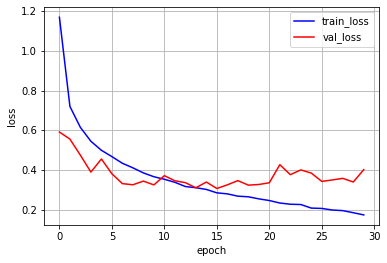

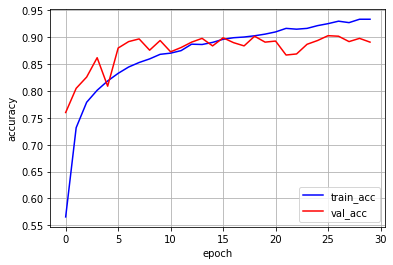

In [ ]:
# Loss & Accuracy
import matplotlib.pyplot as plt

# 学習用データの損失
plt.plot(history.history["loss"],
         color = "blue",
         label = "train_loss")
# 検証用データの損失
plt.plot(history.history["val_loss"],
         color = "red",
         label = "val_loss")
plt.legend(loc = "upper right")       # 凡例
plt.grid()                            # グリッド
plt.xlabel("epoch")                   # x軸
plt.ylabel("loss")                    # y軸
plt.show()

# 学習用データの正確度
plt.plot(history.history["accuracy"],
         color = "blue",
         label = "train_acc")
# 検証用データの損失
plt.plot(history.history["val_accuracy"],
         color = "red",
         label = "val_acc")
plt.legend(loc = "lower right")       # 凡例
plt.grid()                            # グリッド
plt.xlabel("epoch")                   # x軸
plt.ylabel("accuracy")                # y軸
plt.show()

## プーリング層
プーリング層を追加します。畳み込み層の後にプーリング層を1つ挿入します。その後、Flattenを経て全結合層に接続し、出力層に接続するという構成になります。MaxPooling2D()メソッドで、2×2の領域で最大値を取り出します（最大値プーリング）。主な引数に以下があります。
- pool_size：プーリングのサイズ（最大値を取る範囲）
- strides：defaultは"None"で、pool_size（2×2なら、縦と横に2つずつずらす）

ネットワークの構成は以下のようになります。
- 畳み込み層（フィルタ数：32）
- プーリング層（最大値）
- 全結合層
- ドロップアウト
- 全結合層
- ドロップアウト
- 出力層（ユニット数：10）

In [ ]:
#（実行には4分くらいかかります）
# ニューラルネットワークの構成----------------------------
# Neural Network
img_row = 28                # 入力層のユニット数
img_col = 28
unit_middle1 = 256          # 中間層のユニット数
unit_middle2 = 128
unit_output = 10            # 出力層のユニット数
learning_rate = 0.1         # 学習係数
epochs = 30                 # 学習を繰り返す回数（エポック数）
batch_size = 64             # ミニバッチのサイズ


# ニューラルネットワークの構築-----------------------------
# keras.modelsからSequentialをインポート
from tensorflow.keras.models import Sequential
# keras.layersからDenseとFlattenをインポート
from tensorflow.keras.layers import Dense, Flatten, Dropout     # Dropoutを追加
from tensorflow.keras.layers import Conv2D, MaxPooling2D        # MaxPooling2Dを追加
# keras.optimizersからSGDをインポート
from tensorflow.keras.optimizers import SGD

model = Sequential()

# 畳み込み層
model.add(
    Conv2D(
        filters = 32,                   # フィルタの数
        kernel_size = (3, 3),           # フィルタのサイズ
        padding = "same",               # ゼロパディング
        input_shape = (img_row, img_col, 1),      # 入力データの形状
        activation = "relu"             # 活性化関数
    ))

# プーリング層(14, 14, 32)
model.add(
    MaxPooling2D(pool_size = (2, 2)))   # プーリングサイズ

# (28, 28, 32) -> (25088)
model.add(Flatten())

# 中間層
model.add(Dense(unit_middle1, activation = "relu"))    # 中間層1
model.add(Dropout(0.5))                                # 中間層でドロップアウト
model.add(Dense(unit_middle2, activation = "relu"))    # 中間層2
model.add(Dropout(0.5))                                # 中間層でドロップアウト

# 出力層
model.add(Dense(unit_output, activation = "softmax"))

# モデルの概要を出力
model.summary()


# モデルのコンパイル---------------------------------
model.compile(
    optimizer = SGD(learning_rate),            # SGD
    loss = "categorical_crossentropy",         # 交差エントロピー誤差
    metrics = ["accuracy"]                     # 学習評価の指標はaccuracy
)


# 学習を実行し、結果を出力する
print(train_data1.shape, train_label1.shape)
print(valid_data1.shape, valid_label1.shape)
history = model.fit(train_data1,
                    train_label1,
                    epochs = epochs,
                    batch_size = batch_size,
                    verbose = 1,
                    validation_data = (valid_data1, valid_label1)
)



# 検証-----------------------------------------------
# データ抽出
test_data0 = test_data[0:2000, : , : ]
test_label0 = test_label[0:2000]

# データ型
print(test_data0.dtype)
print(test_data0.shape)

# uint8 -> float32
test_data1 = test_data0.astype("float32") / 255

# データ型
print(test_data1.dtype)
print(test_data1.shape)

print("評価用データ")
print(test_data1.min(), "-", test_data1.max())
print(test_label0.min(), "-", test_label0.max())


# ラベルの表示
print("検証用", test_label0, len(test_label0))

# one-hot vector
test_label1 = to_categorical(test_label0)
print("検証用", test_label1, len(test_label1))


# 検証
score = model.evaluate(test_data1, test_label1, verbose = 1)
# 検証用データの誤り率
print("Test Loss : ", score[0])
# 検証用データの正確度
print("Test Accuracy : ", score[1])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 6272)              0         
                                                                 
 dense_3 (Dense)             (None, 256)               1605888   
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                      

損失関数の値、正確度を図示します。

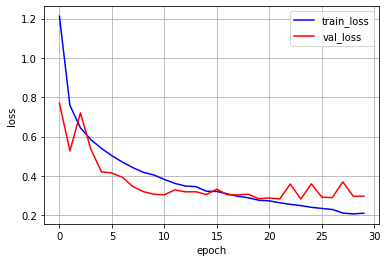

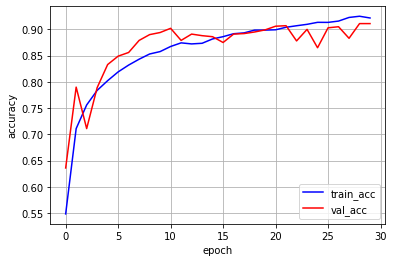

In [ ]:
# Loss & Accuracy
import matplotlib.pyplot as plt

# 学習用データの損失
plt.plot(history.history["loss"],
         color = "blue",
         label = "train_loss")
# 検証用データの損失
plt.plot(history.history["val_loss"],
         color = "red",
         label = "val_loss")
plt.legend(loc = "upper right")       # 凡例
plt.grid()                            # グリッド
plt.xlabel("epoch")                   # x軸
plt.ylabel("loss")                    # y軸
plt.show()

# 学習用データの正確度
plt.plot(history.history["accuracy"],
         color = "blue",
         label = "train_acc")
# 検証用データの損失
plt.plot(history.history["val_accuracy"],
         color = "red",
         label = "val_acc")
plt.legend(loc = "lower right")       # 凡例
plt.grid()                            # グリッド
plt.xlabel("epoch")                   # x軸
plt.ylabel("accuracy")                # y軸
plt.show()

## 畳み込み層とプーリング層をもう1セット追加
畳み込み層とプーリング層をもう1セット追加してみましょう。ネットワークの構成は以下のようになります。
- 畳み込み層（フィルタ数：32）
- プーリング層（最大値）
- 畳み込み層（フィルタ数：64）
- プーリング層（最大値）
- Flatten
- 全結合層
- ドロップアウト
- 全結合層
- ドロップアウト
- 出力層（ユニット数：10）

In [ ]:
#（実行には7分くらいかかります）
# ニューラルネットワークの構成----------------------------
# Neural Network
img_row = 28                # 入力層のユニット数
img_col = 28
unit_middle1 = 256          # 中間層のユニット数
unit_middle2 = 128
unit_output = 10            # 出力層のユニット数
learning_rate = 0.1         # 学習係数
epochs = 30                 # 学習を繰り返す回数（エポック数）
batch_size = 64             # ミニバッチのサイズ


# ニューラルネットワークの構築-----------------------------
# keras.modelsからSequentialをインポート
from tensorflow.keras.models import Sequential
# keras.layersからDenseとFlattenをインポート
from tensorflow.keras.layers import Dense, Flatten, Dropout     # Dropoutを追加
from tensorflow.keras.layers import Conv2D, MaxPooling2D        # MaxPooling2Dを追加
# keras.optimizersからSGDをインポート
from tensorflow.keras.optimizers import SGD

model = Sequential()

# 畳み込み層1
model.add(
    Conv2D(
        filters = 32,                   # フィルタの数
        kernel_size = (3, 3),           # フィルタのサイズ
        padding = "same",               # ゼロパディング
        input_shape = (img_row, img_col, 1),      # 入力データの形状
        activation = "relu"             # 活性化関数
    ))

# プーリング層1(14, 14, 32)
model.add(
    MaxPooling2D(pool_size = (2, 2)))   # プーリングサイズ

# 畳み込み層2
model.add(
    Conv2D(
        filters = 64,                   # フィルタの数
        kernel_size = (3, 3),           # フィルタのサイズ
        padding = "same",               # ゼロパディング
        activation = "relu"             # 活性化関数
    ))

# プーリング層2(7, 7, 64)
model.add(
    MaxPooling2D(pool_size = (2, 2)))   # プーリングサイズ


# (7, 7, 64) -> (3136)
model.add(Flatten())

# 中間層
model.add(Dense(unit_middle1, activation = "relu"))    # 中間層1
model.add(Dropout(0.5))                                # 中間層でドロップアウト
model.add(Dense(unit_middle2, activation = "relu"))    # 中間層2
model.add(Dropout(0.5))                                # 中間層でドロップアウト

# 出力層
model.add(Dense(unit_output, activation = "softmax"))

# モデルの概要を出力
model.summary()


# モデルのコンパイル---------------------------------
model.compile(
    optimizer = SGD(learning_rate),            # SGD
    loss = "categorical_crossentropy",         # 交差エントロピー誤差
    metrics = ["accuracy"]                     # 学習評価の指標はaccuracy
)


# 学習を実行し、結果を出力する
print(train_data1.shape, train_label1.shape)
print(valid_data1.shape, valid_label1.shape)
history = model.fit(train_data1,
                    train_label1,
                    epochs = epochs,
                    batch_size = batch_size,
                    verbose = 1,
                    validation_data = (valid_data1, valid_label1)
)



# 検証-----------------------------------------------
# データ抽出
test_data0 = test_data[0:2000, : , : ]
test_label0 = test_label[0:2000]

# データ型
print(test_data0.dtype)
print(test_data0.shape)

# uint8 -> float32
test_data1 = test_data0.astype("float32") / 255

# データ型
print(test_data1.dtype)
print(test_data1.shape)

print("評価用データ")
print(test_data1.min(), "-", test_data1.max())
print(test_label0.min(), "-", test_label0.max())


# ラベルの表示
print("検証用", test_label0, len(test_label0))

# one-hot vector
test_label1 = to_categorical(test_label0)
print("検証用", test_label1, len(test_label1))


# 検証
score = model.evaluate(test_data1, test_label1, verbose = 1)
# 検証用データの誤り率
print("Test Loss : ", score[0])
# 検証用データの正確度
print("Test Accuracy : ", score[1])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 3136)              0         
                                                                 
 dense_6 (Dense)             (None, 256)              

損失関数の値、正確度を図示します。

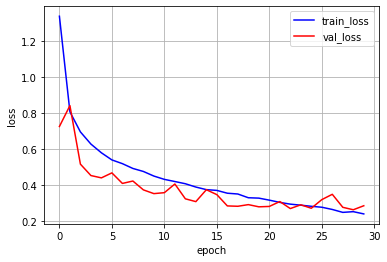

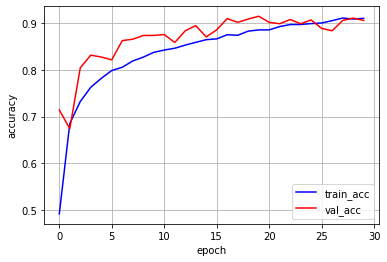

In [ ]:
# Loss & Accuracy
import matplotlib.pyplot as plt

# 学習用データの損失
plt.plot(history.history["loss"],
         color = "blue",
         label = "train_loss")
# 検証用データの損失
plt.plot(history.history["val_loss"],
         color = "red",
         label = "val_loss")
plt.legend(loc = "upper right")       # 凡例
plt.grid()                            # グリッド
plt.xlabel("epoch")                   # x軸
plt.ylabel("loss")                    # y軸
plt.show()

# 学習用データの正確度
plt.plot(history.history["accuracy"],
         color = "blue",
         label = "train_acc")
# 検証用データの損失
plt.plot(history.history["val_accuracy"],
         color = "red",
         label = "val_acc")
plt.legend(loc = "lower right")       # 凡例
plt.grid()                            # グリッド
plt.xlabel("epoch")                   # x軸
plt.ylabel("accuracy")                # y軸
plt.show()